In [5]:

import pandas as pd
import numpy as np
import time
import seaborn as sb
import datetime as dt
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from dateutil import tz

In [2]:
def format_date(t):
    if len(t)<11:
        t = t+' 12:00' #somehow the data is missing the 12pm timem stamp
    date,time = t.split(' ')
    month,day,year = date.split('/')
    hr,sec = time.split(':')

    return dt.datetime(int(year),int(month),int(day),int(hr),int(sec))
        
     

In [50]:

def is_local_max(data, index):
    if(data[index-1][4]<=data[index][4] and data[index][4]>=data[index+1][4]):# and data[index-1][1]<=data[index][4]:

        return True
    return False
def is_local_min(data, index):
    if(data[index-1][4]>=data[index][4] and data[index][4]<=data[index+1][4]):
        return True
    return False
def calc_gradient(pt1,pt2):
    return (pt2[1]-pt1[1])/(pt2[0]-pt1[0])

def detect_asc_triangle2(data, max_size, max_tolerance, number_of_max, number_of_low,min_grad,look_back =15,max_grad = 0.05/290*5 ):
    #max size indicates number of candle sticks
    #max tolerance in BP
    tolerance = max_tolerance/10000
    max_list = []
    min_list = []
    #i want to detect a serious of max
    for i in range(1,len(data)-1):

        if is_local_max(data,i):
            max_list.append((data[i],i))
        
        if is_local_min(data,i):
            min_list.append((data[i],i))

    triangle_max = []
    index = 0
    triangle = []
    while index < len(max_list):

        triangle_min = []
        triangle_max = [max_list[index]]
        not_triangle = False
        j = 1
        last_j = 1
        break_out = 0

        while j+index<=len(max_list)-1 and max_list[index+j][1]<=max_list[index][1]+max_size: 

            if max_list[index+j][0][4]<=max_list[index][0][4]*(1+tolerance) and max_list[index+j][0][4]>=max_list[index][0][4]*(1-tolerance):
                break_out = max_list[index+j][1]
                triangle_max.append(max_list[index+j])
                last_j = j


            if max_list[index+j][0][4]>max_list[index][0][4]*(1+tolerance):

                break_out = max_list[index+j][1]

                break

            j+=1


        if len(triangle_max) < number_of_max: 

            index = index +1
            continue

        if (triangle_max[-1][1] -triangle_max[0][1])<10: # triangel likely to be too small
            index = index +1
            continue
        for i in range(len(min_list)):
            if min_list[i][1]< triangle_max[0][1]-look_back: #too far back
                continue
            if (min_list[i][1]>break_out) :
                break
            triangle_min.append(min_list[i])

        if len(triangle_min)<2:
            index= index+1
  
            continue

        low_index = 0
        for count in range(1,len(triangle_min)): # find the lowest value traingle 
            if triangle_min[count][0][4]<triangle_min[low_index][0][4]:
                low_index = count

        low_grad = 9999
        second_index  = 0 
        if low_index == len(triangle_min)-1:
            index = index+1

            continue
        
        for count in range(low_index+1, len(triangle_min)):
            if triangle_min[count][1] - triangle_min[low_index][1] <5:
                continue
            grad = calc_gradient((triangle_min[low_index][1],triangle_min[low_index][0][4]),\
                                (triangle_min[count][1],triangle_min[count][0][4]))


            if grad<low_grad:
                low_grad = grad
                second_index = count

        if low_grad>max_grad*triangle_min[low_index][0][4]:#use grad* price

            index = index+last_j
  
            continue
        if low_grad<min_grad*triangle_min[low_index][0][4]:
            index = index+1
            continue
            
        if triangle_min[low_index][1] - triangle_max[0][1]>30: # min too far away from max
            index = index + 1
            continue



        triangle.append([triangle_max[0][0],triangle_max[-1][0],triangle_min[low_index][0],triangle_min[second_index][0]])

        index = index+last_j
    return triangle

D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



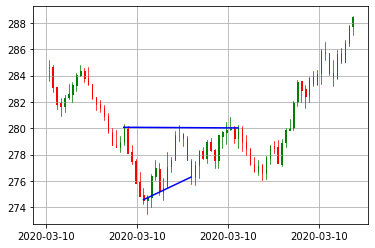

[array(['2020-03-10T15:05:00Z', 278.94, 280.31, 278.75, 280.08, 263960,
       307706.45, nan, nan, nan, nan], dtype=object), array(['2020-03-10T17:30:00Z', 279.27, 280.25, 278.53, 280.03, 382165,
       291666.0, nan, nan, nan, nan], dtype=object), array(['2020-03-10T15:30:00Z', 274.92, 275.45, 274.27, 274.58, 563588,
       307571.15, nan, nan, nan, nan], dtype=object), array(['2020-03-10T16:30:00Z', 277.55, 277.66, 275.79, 276.29, 373465,
       323724.65, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



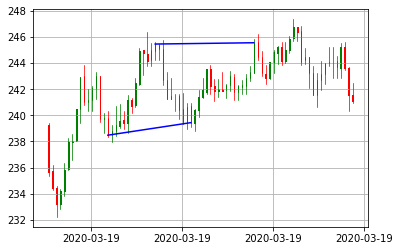

[array(['2020-03-19T15:45:00Z', 244.96, 245.58, 244.25, 245.46, 392750,
       370387.15, nan, nan, nan, nan], dtype=object), array(['2020-03-19T17:50:00Z', 243.27, 245.81, 243.25, 245.56, 389611,
       266955.2, nan, nan, nan, nan], dtype=object), array(['2020-03-19T14:45:00Z', 239.79, 240.3, 238.33, 238.48, 343400,
       646667.8, nan, nan, nan, nan], dtype=object), array(['2020-03-19T16:30:00Z', 240.69, 240.95, 239.13, 239.44, 280319,
       388351.2, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



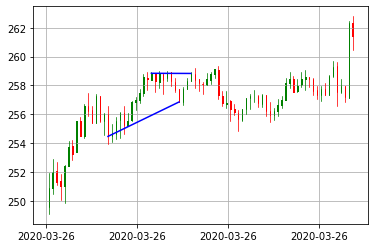

[array(['2020-03-26T15:40:00Z', 258.4, 258.96, 258.38, 258.84, 159854,
       275872.35, nan, nan, nan, nan], dtype=object), array(['2020-03-26T16:30:00Z', 258.33, 258.93, 258.33, 258.83, 110951,
       215630.65, nan, nan, nan, nan], dtype=object), array(['2020-03-26T14:45:00Z', 256.0, 256.54, 253.92, 254.46, 261206,
       511301.2, nan, nan, nan, nan], dtype=object), array(['2020-03-26T16:15:00Z', 257.72, 257.78, 256.85, 256.85, 142073,
       227050.95, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



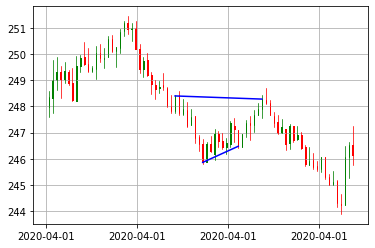

[array(['2020-04-01T16:10:00Z', 247.83, 248.42, 247.74, 248.4, 136780,
       161710.1, nan, nan, nan, nan], dtype=object), array(['2020-04-01T18:00:00Z', 247.9, 248.42, 247.54, 248.28, 146541,
       131248.45, nan, nan, nan, nan], dtype=object), array(['2020-04-01T16:45:00Z', 246.55, 246.76, 245.81, 245.865, 136263,
       158650.25, nan, nan, nan, nan], dtype=object), array(['2020-04-01T17:30:00Z', 247.09, 247.09, 246.43, 246.48, 123628,
       135301.75, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



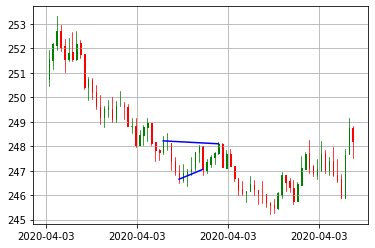

[array(['2020-04-03T15:55:00Z', 247.75, 248.41, 247.69, 248.22, 140561,
       133460.5, nan, nan, nan, nan], dtype=object), array(['2020-04-03T17:05:00Z', 247.73, 248.17, 247.67, 248.1, 55868,
       103051.25, nan, nan, nan, nan], dtype=object), array(['2020-04-03T16:15:00Z', 246.92, 247.24, 246.5, 246.65, 105585,
       110894.4, nan, nan, nan, nan], dtype=object), array(['2020-04-03T16:45:00Z', 248.01, 248.03, 246.81, 247.05, 140698,
       117036.65, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



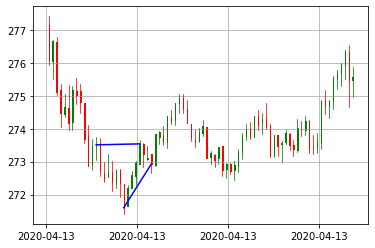

[array(['2020-04-13T14:30:00Z', 273.48, 273.76, 273.04, 273.51, 93161,
       210560.6, nan, nan, nan, nan], dtype=object), array(['2020-04-13T15:25:00Z', 272.94, 273.66, 272.93, 273.54, 77332,
       96055.55, nan, nan, nan, nan], dtype=object), array(['2020-04-13T15:05:00Z', 272.32, 272.32, 271.41, 271.6, 94430,
       118471.0, nan, nan, nan, nan], dtype=object), array(['2020-04-13T15:40:00Z', 273.22, 273.22, 272.64, 272.93, 51655,
       87000.55, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



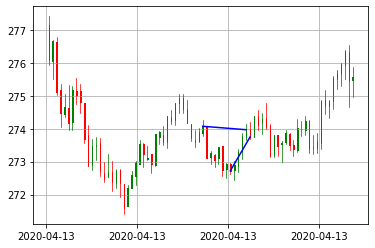

[array(['2020-04-13T16:45:00Z', 273.87, 274.27, 273.79, 274.075, 35438,
       66034.55, nan, nan, nan, nan], dtype=object), array(['2020-04-13T17:40:00Z', 273.76, 274.13, 273.66, 273.97, 79024,
       70870.05, nan, nan, nan, nan], dtype=object), array(['2020-04-13T17:20:00Z', 272.94, 272.96, 272.61, 272.72, 53036,
       66020.2, nan, nan, nan, nan], dtype=object), array(['2020-04-13T17:45:00Z', 273.99, 274.2, 273.68, 273.75, 73092,
       72033.1, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



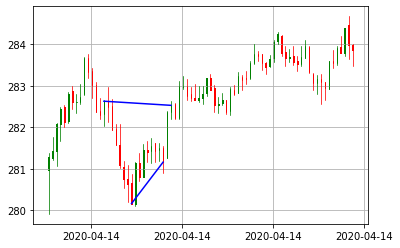

[array(['2020-04-14T14:40:00Z', 282.33, 282.65, 282.02, 282.63, 191111,
       212984.05, nan, nan, nan, nan], dtype=object), array(['2020-04-14T16:05:00Z', 282.37, 282.64, 282.2, 282.53, 106782,
       137300.2, nan, nan, nan, nan], dtype=object), array(['2020-04-14T15:15:00Z', 280.65, 280.87, 280.16, 280.16, 122421,
       165413.75, nan, nan, nan, nan], dtype=object), array(['2020-04-14T15:55:00Z', 281.5, 281.55, 280.9, 281.16, 77796,
       143860.65, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



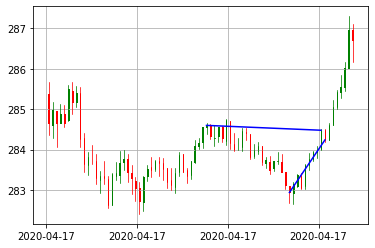

[array(['2020-04-17T16:50:00Z', 284.57, 284.65, 284.39, 284.6, 75702,
       82798.5, nan, nan, nan, nan], dtype=object), array(['2020-04-17T19:15:00Z', 284.02, 284.5, 283.98, 284.48, 59096,
       68420.75, nan, nan, nan, nan], dtype=object), array(['2020-04-17T18:35:00Z', 283.11, 283.11, 282.68, 282.94, 90304,
       81322.65, nan, nan, nan, nan], dtype=object), array(['2020-04-17T19:20:00Z', 284.48, 284.5, 284.19, 284.24, 54715,
       68738.75, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



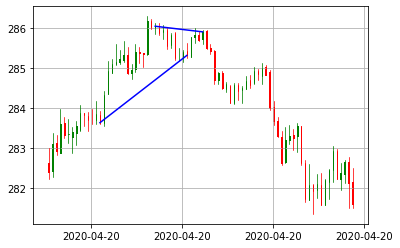

[array(['2020-04-20T15:45:00Z', 285.995, 286.13, 285.85, 286.04, 40634,
       80345.0, nan, nan, nan, nan], dtype=object), array(['2020-04-20T16:45:00Z', 285.71, 285.935, 285.59, 285.9, 51202,
       61718.4, nan, nan, nan, nan], dtype=object), array(['2020-04-20T14:35:00Z', 283.82, 283.93, 283.6, 283.63, 64000,
       212426.75, nan, nan, nan, nan], dtype=object), array(['2020-04-20T16:25:00Z', 285.41, 285.62, 285.25, 285.31, 81451,
       67748.15, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



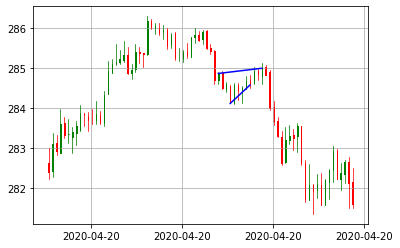

[array(['2020-04-20T17:05:00Z', 284.7, 284.9, 284.605, 284.86, 78826,
       61494.0, nan, nan, nan, nan], dtype=object), array(['2020-04-20T18:00:00Z', 284.8, 285.13, 284.59, 284.99, 50955,
       53332.95, nan, nan, nan, nan], dtype=object), array(['2020-04-20T17:20:00Z', 284.54, 284.57, 284.11, 284.11, 39929,
       56128.0, nan, nan, nan, nan], dtype=object), array(['2020-04-20T17:45:00Z', 284.7, 284.83, 284.49, 284.57, 31307,
       55719.15, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



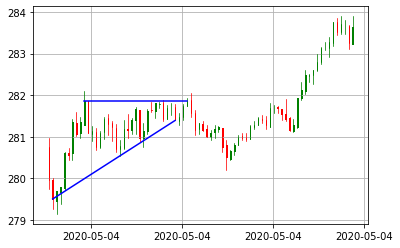

[array(['2020-05-04T14:15:00Z', 281.28, 282.11, 281.27, 281.86, 148977,
       251446.9, nan, nan, nan, nan], dtype=object), array(['2020-05-04T16:25:00Z', 281.74, 281.94, 281.74, 281.86, 57076,
       74048.8, nan, nan, nan, nan], dtype=object), array(['2020-05-04T13:35:00Z', 279.96, 280.01, 279.27, 279.5, 263072,
       223849.4, nan, nan, nan, nan], dtype=object), array(['2020-05-04T16:10:00Z', 281.71, 281.78, 281.39, 281.39, 40088,
       82465.35, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



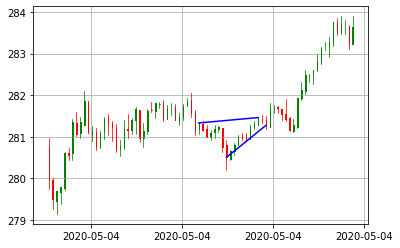

[array(['2020-05-04T16:40:00Z', 281.18, 281.33, 281.06, 281.33, 46652,
       67899.55, nan, nan, nan, nan], dtype=object), array(['2020-05-04T17:55:00Z', 281.29, 281.48, 281.29, 281.46, 83671,
       63819.45, nan, nan, nan, nan], dtype=object), array(['2020-05-04T17:15:00Z', 280.79, 280.91, 280.2, 280.5, 137953,
       62264.6, nan, nan, nan, nan], dtype=object), array(['2020-05-04T18:05:00Z', 281.41, 281.49, 281.19, 281.27, 83970,
       67654.05, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



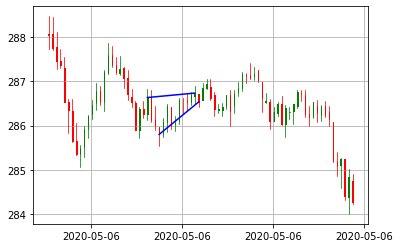

[array(['2020-05-06T15:35:00Z', 286.27, 286.82, 286.12, 286.63, 108826,
       126299.6, nan, nan, nan, nan], dtype=object), array(['2020-05-06T16:35:00Z', 286.66, 286.89, 286.49, 286.73, 64013,
       79805.35, nan, nan, nan, nan], dtype=object), array(['2020-05-06T15:50:00Z', 285.97, 285.97, 285.53, 285.8, 94173,
       114097.85, nan, nan, nan, nan], dtype=object), array(['2020-05-06T16:40:00Z', 286.715, 286.72, 286.41, 286.53, 33852,
       78122.8, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



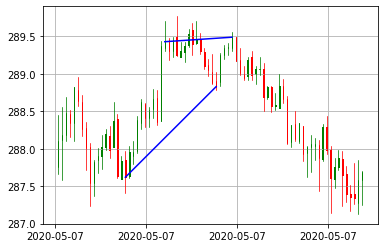

[array(['2020-05-07T15:45:00Z', 289.35, 289.7, 289.3, 289.43, 134094,
       89370.3, nan, nan, nan, nan], dtype=object), array(['2020-05-07T17:10:00Z', 289.35, 289.56, 289.31, 289.49, 43601,
       61201.8, nan, nan, nan, nan], dtype=object), array(['2020-05-07T14:55:00Z', 287.85, 287.97, 287.41, 287.62, 175288,
       149037.7, nan, nan, nan, nan], dtype=object), array(['2020-05-07T16:50:00Z', 288.91, 289.03, 288.78, 288.83, 44583,
       68678.05, nan, nan, nan, nan], dtype=object)]


D:\Program\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



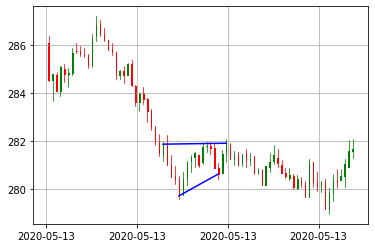

[array(['2020-05-13T15:55:00Z', 281.43, 281.95, 281.19, 281.87, 243297,
       143724.85, nan, nan, nan, nan], dtype=object), array(['2020-05-13T17:15:00Z', 281.49, 282.07, 281.13, 281.91, 61307,
       154982.3, nan, nan, nan, nan], dtype=object), array(['2020-05-13T16:15:00Z', 280.41, 280.56, 279.61, 279.72, 234984,
       164811.7, nan, nan, nan, nan], dtype=object), array(['2020-05-13T17:05:00Z', 280.89, 281.1, 280.43, 280.63, 83374,
       163949.3, nan, nan, nan, nan], dtype=object)]


In [56]:

def convert_iso_NY_datetime(date):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc = dt.datetime.strptime(date,"%Y-%m-%dT%H:%M:%SZ")
    utc = utc.replace(tzinfo=from_zone)
    central = utc.astimezone(to_zone)
    return central


data = pd.read_csv('spy5min.csv')


asc_data = data.to_numpy()
triangle  =detect_asc_triangle2(asc_data, 40, 5,2,1,0.05/290)
for pt in triangle:
    day0 =pt[0][0].split('T')[0]
    day1 =pt[1][0].split('T')[0]
    if day0!=day1 or pt[2][0].split('T')[0] != pt[3][0].split('T')[0] :
        continue
    fig = plt.figure()
    ax1 = fig.add_subplot(111) # in this function, first number 1 represent the height,
    # second is for width and third is the plot number
    ax2 = fig.add_subplot(111) # make sure both have same arguments for add_subplot function


    df = pd.read_csv('spy5min.csv')
    day0_con = df.Date.str.contains(day0)
    day1_con = df.Date.str.contains(day1)
    df0 = df[day0_con]
    df1 = df[day1_con]
    df = pd.concat([df0, df1], axis=0)
    df['Date'] = df['Date'].apply(convert_iso_NY_datetime)
    df['Date'] = df['Date'].apply(mdates.date2num)
    df= df.to_numpy()
    # it is in the same expected order    date,open,high,low,close
    candlestick_ohlc(ax1, df, width=0.0004, colorup='g', colordown='r', alpha=1)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(4))
    ax1.grid(True)
    ax2.plot([mdates.date2num(convert_iso_NY_datetime(pt[0][0])),\
              mdates.date2num(convert_iso_NY_datetime(pt[1][0]))],\
              [pt[0][4], pt[1][4]],color = 'b')
    ax2.plot([mdates.date2num(convert_iso_NY_datetime(pt[2][0])),\
              mdates.date2num(convert_iso_NY_datetime(pt[3][0]))],\
              [pt[2][4], pt[3][4]],color = 'b')
    plt.show()
    print(pt)


In [54]:
print(triangle)

[[array(['2020-03-10T15:05:00Z', 278.94, 280.31, 278.75, 280.08, 263960,
       307706.45, nan, nan, nan, nan], dtype=object), array(['2020-03-10T17:30:00Z', 279.27, 280.25, 278.53, 280.03, 382165,
       291666.0, nan, nan, nan, nan], dtype=object), array(['2020-03-10T15:30:00Z', 274.92, 275.45, 274.27, 274.58, 563588,
       307571.15, nan, nan, nan, nan], dtype=object), array(['2020-03-10T16:30:00Z', 277.55, 277.66, 275.79, 276.29, 373465,
       323724.65, nan, nan, nan, nan], dtype=object)], [array(['2020-03-19T15:45:00Z', 244.96, 245.58, 244.25, 245.46, 392750,
       370387.15, nan, nan, nan, nan], dtype=object), array(['2020-03-19T17:50:00Z', 243.27, 245.81, 243.25, 245.56, 389611,
       266955.2, nan, nan, nan, nan], dtype=object), array(['2020-03-19T14:45:00Z', 239.79, 240.3, 238.33, 238.48, 343400,
       646667.8, nan, nan, nan, nan], dtype=object), array(['2020-03-19T16:30:00Z', 240.69, 240.95, 239.13, 239.44, 280319,
       388351.2, nan, nan, nan, nan], dtype=object)], 